In [4]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

In [5]:
# convert data to torch.FloatTensor
transform=transforms.ToTensor()
# load the training and test datasets
train_data=datasets.MNIST(root='data',train=True,transform=transform,download=True)
test_data=datasets.MNIST(root='data',train=False,transform=transform,download=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# Create training and test dataloaders
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader =torch.utils.data.DataLoader(train_data,batch_size=batch_size,num_workers=num_workers)
# prepare data loaders
test_loader =torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)

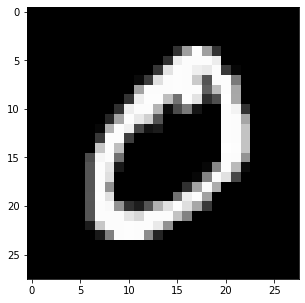

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[1])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
  def __init__(self):
    super().__init__()
    ## encoder layers ##
    # conv layer (depth from 1 --> 32), 3x3 kernels
    self.conv1=nn.Conv2d(1,32,3,padding=1)
    # conv layer (depth from 32 --> 16), 3x3 kernels
    self.conv2=nn.Conv2d(32,16,3,padding=1)
    # conv layer (depth from 16 --> 8), 3x3 kernels
    self.conv3=nn.Conv2d(16,8,3,padding=1)
    # pooling layer to reduce x-y dims by two; kernel and stride of 2
    self.pool=nn.MaxPool2d(2,2)

    ## decoder layers ##
    # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        
    self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
    # two more transpose layers with a kernel of 2
    self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
    self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
    # one, final, normal conv layer to decrease the depth
    self.conv_out = nn.Conv2d(32, 1, 3, padding=1)

  def forward(self,x):
    ## encode ##
    # add hidden layers with relu activation function
    # and maxpooling after

    x=F.relu(self.conv1(x))
    x=self.pool(x)
    # add second hidden layer
    x=F.relu(self.conv2(x))
    x=self.pool(x)
    x=F.relu(self.conv3(x))
    x=self.pool(x)# compressed representation

    ## decode ##
    # add transpose conv layers, with relu activation function
    x=F.relu(self.t_conv1(x))
    x=F.relu(self.t_conv2(x))
    x=F.relu(self.t_conv3(x))
    x=F.sigmoid(self.conv_out(x))


    return x  

# initialize the NN
model=ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [9]:
# specify loss function
criterion=nn.MSELoss()
optim=torch.optim.Adam(model.parameters(),lr=0.0001)

In [12]:
# number of epochs to train the model
n_epochs = 20

# for adding noise to images
noise_factor=0.5
for  i in range(1,n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
      img,lab=data
      #print(img.shape)
      ## add random noise to the input images
      noise_imgs=img+noise_factor*torch.randn(*img.shape)
      # Clip the images to be between 0 and 1
      noise_imgs=np.clip(noise_imgs,0.,1.)
      # clear the gradients of all optimized variables
      optim.zero_grad()
      ## forward pass: compute predicted outputs by passing *noisy* images to the model
      outs=model(noise_imgs)
      # calculate the loss
      # the "target" is still the original, not-noisy images 
      loss=criterion(outs,img )
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optim.step()
      # update running training loss
      train_loss+=loss.item()*img.size(0)
      
    # print avg training statistics 
    train_loss/=len(train_loader)   
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        i, 
        train_loss
        ))

  

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.894703
Epoch: 2 	Training Loss: 0.780318
Epoch: 3 	Training Loss: 0.717865
Epoch: 4 	Training Loss: 0.681969
Epoch: 5 	Training Loss: 0.660161
Epoch: 6 	Training Loss: 0.644696
Epoch: 7 	Training Loss: 0.632246
Epoch: 8 	Training Loss: 0.621829
Epoch: 9 	Training Loss: 0.613189
Epoch: 10 	Training Loss: 0.605116
Epoch: 11 	Training Loss: 0.597194
Epoch: 12 	Training Loss: 0.590208
Epoch: 13 	Training Loss: 0.584115
Epoch: 14 	Training Loss: 0.578432
Epoch: 15 	Training Loss: 0.573075
Epoch: 16 	Training Loss: 0.568183
Epoch: 17 	Training Loss: 0.562997
Epoch: 18 	Training Loss: 0.558709
Epoch: 19 	Training Loss: 0.554762
Epoch: 20 	Training Loss: 0.550910


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


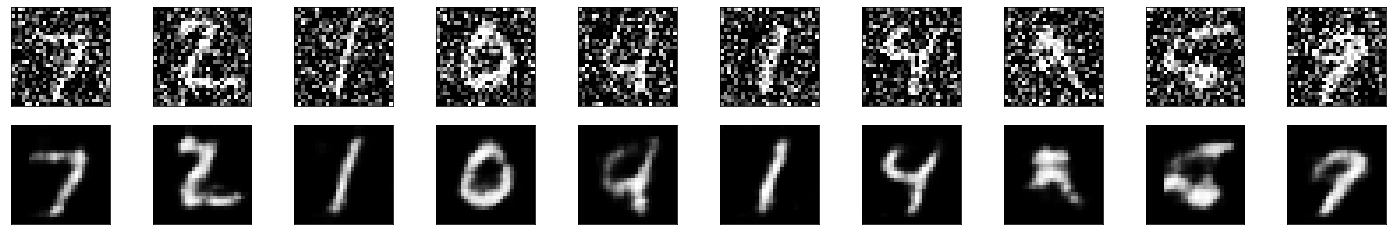

In [18]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs)
# prep images for display
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Auto-encoders can also be used for Dimensionality Reduction. i.e, tranforming data from a higher dimension to a lower dimension